In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import re

plt.rcParams["figure.dpi"] = 140  # nicer plots

In [2]:
def load_run_file(path):
    """
    Reads one agent_results_*.json file and returns:
    - df_meta: 1 row summarizing the whole run (runtime, qps, ingest, etc.)
    - df_q:   one row per question (latency breakdown, tokens, cache stats, etc.)
    """
    with open(path, "r") as f:
        raw = json.load(f)

    meta_rows = []
    q_rows = []

    for rec in raw:
        if rec.get("record_type") == "run_meta":
            meta_rows.append({
                "run_type": rec.get("run_type"),
                "summary_total_runtime_s": rec.get("summary_total_runtime_s"),
                "summary_avg_per_question_s": rec.get("summary_avg_per_question_s"),
                "summary_questions": rec.get("summary_questions"),
                "summary_qps": rec.get("summary_qps"),
                "ingest_time_s": rec.get("ingest_time_s"),
                "index_build_time_s": rec.get("index_build_time_s"),
            })
        elif rec.get("record_type") == "question_result":
            cb = rec.get("callback_timing", {}) or {}

            q_rows.append({
                "run_type": rec.get("run_type"),
                "question_number": rec.get("question_number"),
                "question": rec.get("question"),
                "raw_response": rec.get("raw_response", ""),

                # latency breakdown
                "elapsed_time_s": rec.get("elapsed_time"),
                "T_total_s": cb.get("T_total"),
                "T_retrieve_s": cb.get("T_retrieve"),
                "T_reason_s": cb.get("T_reason"),
                "T_generate_s": cb.get("T_generate"),

                # token usage
                "prompt_tokens": cb.get("prompt_tokens"),
                "completion_tokens": cb.get("completion_tokens"),
                "total_tokens": cb.get("total_tokens"),

                # cache stats
                "cache_hits": cb.get("cache_hits", 0),
                "cache_misses": cb.get("cache_misses", 0),
                "warm_cache_retrieval_time_ms": rec.get("warm_cache_retrieval_time_ms", 0),

                # dynamic-k retrieval quality (may be missing in Experiment A)
                "k_used": rec.get("k_used"),
                "precision_at_k": rec.get("graded_precision_at_k"),
                "recall_at_k": rec.get("graded_recall_at_k")
            })

    df_meta = pd.DataFrame(meta_rows)
    df_q = pd.DataFrame(q_rows)

    # normalize warm_cache_retrieval_time_ms: replace NaN with 0 for clean display
    if "warm_cache_retrieval_time_ms" in df_q.columns:
        df_q["warm_cache_retrieval_time_ms"] = df_q["warm_cache_retrieval_time_ms"].fillna(0)

    return df_meta, df_q

In [3]:
def is_valid_structured_answer(raw_response_str: str) -> int:
    """
    Heuristic: treat the answer as 'accurate' if it looks like the agent
    produced structured JSON with query / data_values / computed_values.
    """
    if not isinstance(raw_response_str, str):
        return 0
    needed = [
        "\"query\":",
        "\"data_values\":",
        "\"computed_values\":"
    ]
    return int(all(k in raw_response_str for k in needed))

# SCENARIO A: CACHING ONLY 

## Files: 
- agent_results_baseline_cache.json
- agent_results_optimized_cache.json


In [4]:
meta_A_base, q_A_base = load_run_file("agent_results_baseline_cache.json")
meta_A_opt,  q_A_opt  = load_run_file("agent_results_optimized_cache.json")

# add experiment label
meta_A_base["experiment"] = "cache_only"
meta_A_opt["experiment"]  = "cache_only"
q_A_base["experiment"]    = "cache_only"
q_A_opt["experiment"]     = "cache_only"

# combine baseline+optimized for this experiment
df_meta_A = pd.concat([meta_A_base, meta_A_opt], ignore_index=True)
df_q_A    = pd.concat([q_A_base,    q_A_opt],    ignore_index=True)


In [5]:
cols_question_view = [
    "experiment",
    "run_type",
    "question_number",
    "elapsed_time_s",
    "T_total_s",
    "T_retrieve_s",
    "T_reason_s",
    "T_generate_s",
    "prompt_tokens",
    "completion_tokens",
    "total_tokens",
    "cache_hits",
    "cache_misses",
    "warm_cache_retrieval_time_ms",
    "k_used",
    "precision_at_k",
    "recall_at_k",
]

display(
    df_q_A[cols_question_view]
    .sort_values(["run_type","question_number"])
    .reset_index(drop=True)
)

,experiment,run_type,question_number,elapsed_time_s,T_total_s,T_retrieve_s,T_reason_s,T_generate_s,prompt_tokens,completion_tokens,total_tokens,cache_hits,cache_misses,warm_cache_retrieval_time_ms,k_used,precision_at_k,recall_at_k
0,cache_only,baseline,1,19.273059,19.3086,0.3260,18.9372,12.2020,2855,971,3826,0,1,0.000000,12,0.833333,1.000000
1,cache_only,baseline,2,10.992176,13.0009,0.3726,12.6129,9.1006,2473,760,3233,0,1,0.000000,12,0.545455,0.666667
2,cache_only,baseline,3,13.941042,10.9511,0.4188,10.5148,5.6389,2646,913,3559,0,1,0.000000,12,0.500000,0.666667
3,cache_only,optimized,1,10.647843,10.6723,0.3462,9.7645,7.8900,2834,1037,3871,1,0,475.579262,12,0.791667,1.000000
4,cache_only,optimized,2,9.716285,9.7285,0.3605,9.3481,4.7336,2466,754,3220,1,0,340.564013,12,0.416667,0.666667
5,cache_only,optimized,3,10.399966,10.4139,0.3884,9.9957,5.3859,2646,928,3574,1,0,433.016777,12,0.454545,0.500000


In [6]:
cols_meta_view = [
    "experiment",
    "run_type",
    "summary_total_runtime_s",
    "summary_avg_per_question_s",
    "summary_questions",
    "summary_qps",
    "ingest_time_s",
    "index_build_time_s",
]

display(
    df_meta_A[cols_meta_view]
    .sort_values(["run_type"])
    .reset_index(drop=True)
)

,experiment,run_type,summary_total_runtime_s,summary_avg_per_question_s,summary_questions,summary_qps,ingest_time_s,index_build_time_s
0,cache_only,baseline,44.417556,14.805852,3,0.067541,0.163120,43.845868
1,cache_only,optimized,33.319774,11.106591,3,0.090037,0.138727,38.485296


In [7]:
latency_stats_A = (
    df_q_A
    .groupby(["run_type"])["elapsed_time_s"]
    .quantile([0.5, 0.95])
    .unstack(level=-1)
    .rename(columns={0.5:"p50", 0.95:"p95"})
)

display(latency_stats_A)

,p50,p95
run_type,,
baseline,13.941042,18.739858
optimized,10.399966,10.623055


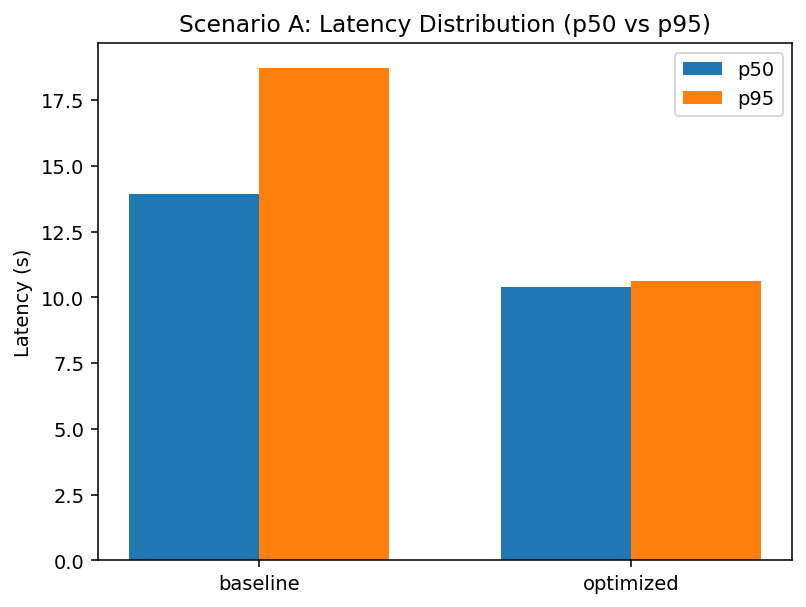

In [8]:
# make it plot-friendly
latency_stats_A_plot = latency_stats_A.reset_index()

# pull arrays
labels = latency_stats_A_plot["run_type"].tolist()        # ['baseline','optimized']
p50_vals = latency_stats_A_plot["p50"].to_numpy(dtype=float)
p95_vals = latency_stats_A_plot["p95"].to_numpy(dtype=float)

x = np.arange(len(labels))  # positions for baseline / optimized
width = 0.35                # bar width

plt.figure()
plt.bar(x - width/2, p50_vals, width, label="p50")
plt.bar(x + width/2, p95_vals, width, label="p95")

plt.xticks(x, labels)
plt.ylabel("Latency (s)")
plt.title("Scenario A: Latency Distribution (p50 vs p95)")
plt.legend()
plt.show()

# SCENARIO B: CACHING + DYNAMIC K

## Files: 
- agent_results_baseline_dynamicK.json
- agent_results_optimized_dynamicK.json

In [9]:
meta_B_base, q_B_base = load_run_file("agent_results_baseline_dynamicK.json")
meta_B_opt,  q_B_opt  = load_run_file("agent_results_optimized_dynamicK.json")

# add experiment label
meta_B_base["experiment"] = "cache + dynamic K"
meta_B_opt["experiment"]  = "cache + dynamic K"
q_B_base["experiment"]    = "cache + dynamic K"
q_B_opt["experiment"]     = "cache + dynamic K"

# combine baseline+optimized for experiment B
df_meta_B = pd.concat([meta_B_base, meta_B_opt], ignore_index=True)
df_q_B    = pd.concat([q_B_base,    q_B_opt],    ignore_index=True)

In [10]:
display(
    df_q_B[cols_question_view]
    .sort_values(["run_type","question_number"])
    .reset_index(drop=True)
)

,experiment,run_type,question_number,elapsed_time_s,T_total_s,T_retrieve_s,T_reason_s,T_generate_s,prompt_tokens,completion_tokens,total_tokens,cache_hits,cache_misses,warm_cache_retrieval_time_ms,k_used,precision_at_k,recall_at_k
0,cache + dynamic K,baseline,1,10.518223,9.8037,0.3372,9.4643,6.8085,2855,1035,3890,1,0,384.812832,12,0.791667,1.000000
1,cache + dynamic K,baseline,2,9.516285,9.6752,0.3325,9.2422,9.0706,2502,789,3291,1,0,378.154516,12,0.416667,0.666667
2,cache + dynamic K,baseline,3,10.185331,10.1806,0.4317,9.7483,6.7451,2645,871,3516,1,0,410.250187,12,0.454545,0.500000
3,cache + dynamic K,optimized,1,13.502749,13.5263,0.3407,13.1544,7.6064,2786,949,3735,1,0,402.195692,5,1.000000,1.000000
4,cache + dynamic K,optimized,2,9.491008,9.4973,0.3953,9.0888,5.9456,2404,774,3178,1,0,400.163889,3,0.500000,0.500000
5,cache + dynamic K,optimized,3,11.416574,11.4224,0.4226,10.9874,5.8826,2601,927,3528,1,0,385.022163,3,0.500000,0.500000


In [11]:
display(
    df_meta_B[cols_meta_view]
    .sort_values(["run_type"])
    .reset_index(drop=True)
)

,experiment,run_type,summary_total_runtime_s,summary_avg_per_question_s,summary_questions,summary_qps,ingest_time_s,index_build_time_s
0,cache + dynamic K,baseline,33.619266,11.306570,3,0.089844,0.130800,36.845473
1,cache + dynamic K,optimized,36.104375,12.034792,3,0.083092,0.136134,35.544225


In [12]:
latency_stats_B = (
    df_q_B
    .groupby(["run_type"])["elapsed_time_s"]
    .quantile([0.5, 0.95])
    .unstack(level=-1)
    .rename(columns={0.5:"p50", 0.95:"p95"})
)

display(latency_stats_B)

,p50,p95
run_type,,
baseline,10.185331,10.484933
optimized,11.416574,13.294131


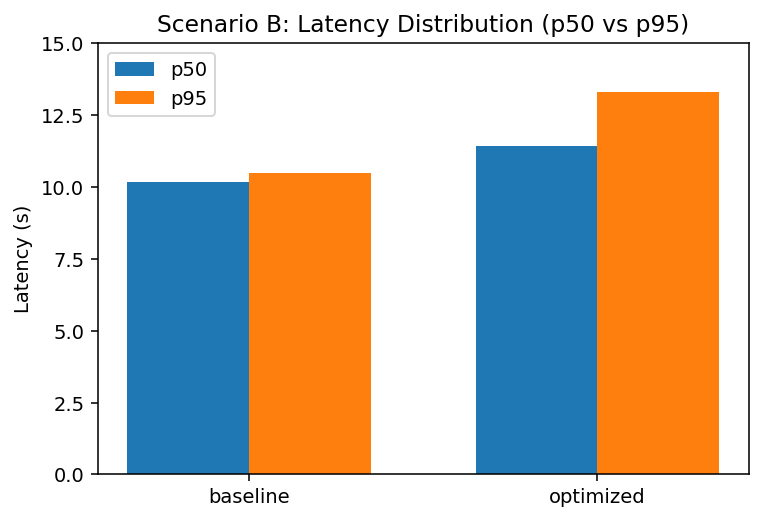

In [13]:
# make it plot-friendly
latency_stats_B_plot = latency_stats_B.reset_index()

# pull arrays
labels   = latency_stats_B_plot["run_type"].tolist()
p50_vals = latency_stats_B_plot["p50"].to_numpy(dtype=float)
p95_vals = latency_stats_B_plot["p95"].to_numpy(dtype=float)

x = np.arange(len(labels))
width = 0.35

fig = plt.figure(figsize=(6,4))
ax = plt.gca()

ax.bar(x - width/2, p50_vals, width, label="p50")
ax.bar(x + width/2, p95_vals, width, label="p95")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Latency (s)")
ax.set_title("Scenario B: Latency Distribution (p50 vs p95)")
ax.legend()

# --- y-axis in increments of 2.5 ---
ax.yaxis.set_major_locator(MultipleLocator(2.5))
# nice top limit at a multiple of 2.5
ymax = float(np.nanmax([p50_vals.max(), p95_vals.max()]))
ymax = np.ceil(ymax / 2.5) * 2.5
ax.set_ylim(0, ymax)


plt.show()

In [15]:
retrieval_quality_B = (
    df_q_B.groupby("run_type")[["precision_at_k","recall_at_k"]]
    .mean()
    .rename(columns={
        "precision_at_k": "avg_precision_at_k",
        "recall_at_k": "avg_recall_at_k"
    })
)

display(retrieval_quality_B)

,avg_precision_at_k,avg_recall_at_k
run_type,,
baseline,0.554293,0.722222
optimized,0.666667,0.666667


In [16]:
# Combine Experiment A and B question-level views into one table
combined_q = (
    pd.concat(
        [
            df_q_A.assign(experiment="cache only")[cols_question_view],
            df_q_B.assign(experiment="cache + dynamic K")[cols_question_view],
        ],
        ignore_index=True,
    )
    .reindex(columns=["experiment", *cols_question_view])  # put experiment first
    .sort_values(["question_number", "run_type"], kind="mergesort")  # stable sort
    .reset_index(drop=True)
)

combined_q = combined_q.loc[:, ~combined_q.columns.duplicated()]
display(combined_q)

,experiment,run_type,question_number,elapsed_time_s,T_total_s,T_retrieve_s,T_reason_s,T_generate_s,prompt_tokens,completion_tokens,total_tokens,cache_hits,cache_misses,warm_cache_retrieval_time_ms,k_used,precision_at_k,recall_at_k
0,cache only,baseline,1,19.273059,19.3086,0.3260,18.9372,12.2020,2855,971,3826,0,1,0.000000,12,0.833333,1.000000
1,cache + dynamic K,baseline,1,10.518223,9.8037,0.3372,9.4643,6.8085,2855,1035,3890,1,0,384.812832,12,0.791667,1.000000
2,cache only,optimized,1,10.647843,10.6723,0.3462,9.7645,7.8900,2834,1037,3871,1,0,475.579262,12,0.791667,1.000000
3,cache + dynamic K,optimized,1,13.502749,13.5263,0.3407,13.1544,7.6064,2786,949,3735,1,0,402.195692,5,1.000000,1.000000
4,cache only,baseline,2,10.992176,13.0009,0.3726,12.6129,9.1006,2473,760,3233,0,1,0.000000,12,0.545455,0.666667
5,cache + dynamic K,baseline,2,9.516285,9.6752,0.3325,9.2422,9.0706,2502,789,3291,1,0,378.154516,12,0.416667,0.666667
6,cache only,optimized,2,9.716285,9.7285,0.3605,9.3481,4.7336,2466,754,3220,1,0,340.564013,12,0.416667,0.666667
7,cache + dynamic K,optimized,2,9.491008,9.4973,0.3953,9.0888,5.9456,2404,774,3178,1,0,400.163889,3,0.500000,0.500000
8,cache only,baseline,3,13.941042,10.9511,0.4188,10.5148,5.6389,2646,913,3559,0,1,0.000000,12,0.500000,0.666667
9,cache + dynamic K,baseline,3,10.185331,10.1806,0.4317,9.7483,6.7451,2645,871,3516,1,0,410.250187,12,0.454545,0.500000


In [17]:
# Helper to compute p50/p95 for a question-level DF
def latency_pstats(df, label):
    out = (
        df.groupby("run_type")["elapsed_time_s"]
          .quantile([0.5, 0.95])
          .unstack(level=-1)
          .rename(columns={0.5: "p50", 0.95: "p95"})
          .assign(experiment=label)
          .reset_index()[["experiment", "run_type", "p50", "p95"]]
    )
    return out

lat_A = latency_pstats(df_q_A, "cache only")
lat_B = latency_pstats(df_q_B, "cache + dynamic K")

# Tall table
latency_both = (
    pd.concat([lat_A, lat_B], ignore_index=True)
      .sort_values(["experiment", "run_type"])
      .reset_index(drop=True)
)
display(latency_both)

,experiment,run_type,p50,p95
0,cache + dynamic K,baseline,10.185331,10.484933
1,cache + dynamic K,optimized,11.416574,13.294131
2,cache only,baseline,13.941042,18.739858
3,cache only,optimized,10.399966,10.623055


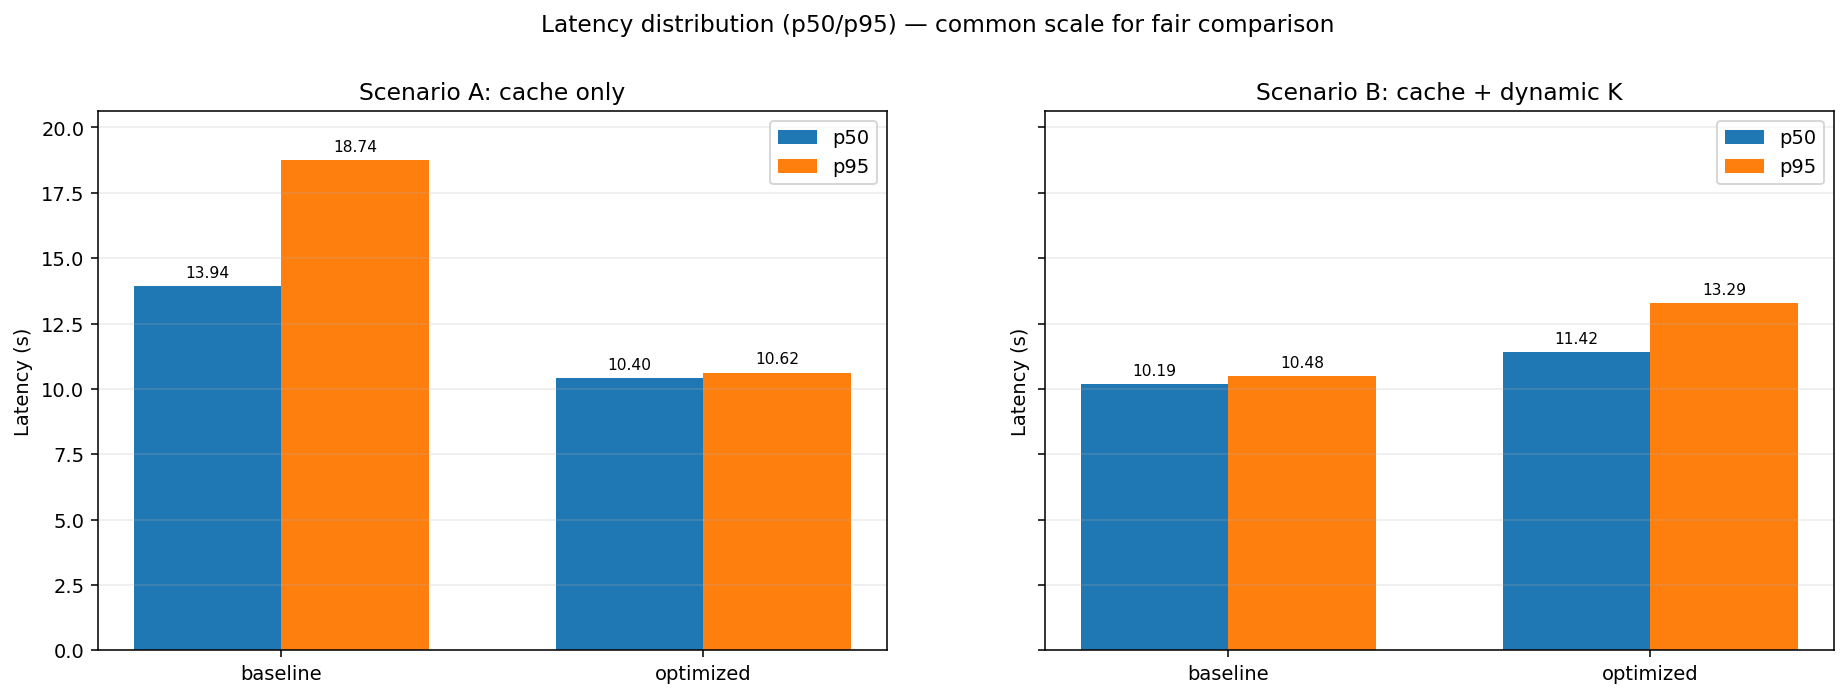

In [18]:
# --- helper unchanged, but allow optional y_max ---
def plot_latency_pair(ax, latency_stats, title, y_max=None):
    dfp = latency_stats.reset_index().copy()
    if set(dfp["run_type"]) >= {"baseline", "optimized"}:
        dfp = dfp.set_index("run_type").loc[["baseline", "optimized"]].reset_index()

    labels = dfp["run_type"].tolist()
    p50_vals = dfp["p50"].to_numpy(dtype=float)
    p95_vals = dfp["p95"].to_numpy(dtype=float)

    x = np.arange(len(labels))
    width = 0.35
    b1 = ax.bar(x - width/2, p50_vals, width, label="p50")
    b2 = ax.bar(x + width/2, p95_vals, width, label="p95")

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Latency (s)")
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.25)
    if y_max is not None:
        ax.set_ylim(0, y_max)
    ax.legend()

    # annotate values
    for b in list(b1) + list(b2):
        h = b.get_height()
        ax.annotate(f"{h:.2f}", (b.get_x()+b.get_width()/2, h),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom", fontsize=8)

# --- common y-limit across both scenarios ---
def _max_val(df): 
    return float(np.nanmax(df[["p50","p95"]].to_numpy()))
y_max = max(_max_val(latency_stats_A), _max_val(latency_stats_B)) * 1.10

# --- build figure with extra horizontal spacing ---
fig, axes = plt.subplots(
    1, 2, figsize=(16, 5), sharey=True,
    gridspec_kw={"wspace": 0.20} 
)

plot_latency_pair(axes[0], latency_stats_A, "Scenario A: cache only", y_max=y_max)
plot_latency_pair(axes[1], latency_stats_B, "Scenario B: cache + dynamic K", y_max=y_max)

fig.suptitle("Latency distribution (p50/p95) — common scale for fair comparison", y=1.02)
plt.show()
